# DEDS Week 9

## Imports

In [116]:
import pyodbc
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

## Database connecties

In [117]:
DB_GO = {
    "servername" : r"VISSIE\SQLEXPRESS",
    "database" : "GREAT_OUTDOORS"}

export_conn_go = pyodbc.connect(f"""DRIVER={'SQL SERVER'};
                             SERVER={DB_GO['servername']};
                             DATABASE={DB_GO['database']};
                             Trusted_Connection=yes
                             """)

export_cursor_go = export_conn_go.cursor()

## Dataframes maken

In [131]:
def create_dataframes_sql(connection):
    dictionary : dict = {}
    query = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE';"
    key = "TABLE_NAME"
    
    tables = pd.read_sql(query, connection)
    
    for table in tables[key].tolist():
        dictionary[table] = pd.read_sql(f"SELECT * FROM {table}", connection)
    
    return dictionary

sdm_frames = create_dataframes_sql(export_conn_go)

orders = sdm_frames["order_details"]
inventory = sdm_frames["inventory"]

orders_specfic = orders[["QUANTITY", "UNIT_COST", "UNIT_PRICE", "UNIT_SALES_PRICE"]]
orders_specfic["TOTAL_COSTS"] = orders["QUANTITY"] * orders["UNIT_COST"]
orders_specfic["REVENUE"] = orders["QUANTITY"] * orders["UNIT_SALES_PRICE"]
orders_specfic["PROFIT"] = (orders["UNIT_PRICE"] * orders["QUANTITY"]) - orders_specfic["TOTAL_COSTS"]
orders_specfic

C:\Users\jdvis_x5odeao\AppData\Local\Temp\ipykernel_36256\1596342658.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tables = pd.read_sql(query, connection)
C:\Users\jdvis_x5odeao\AppData\Local\Temp\ipykernel_36256\1596342658.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dictionary[table] = pd.read_sql(f"SELECT * FROM {table}", connection)
C:\Users\jdvis_x5odeao\AppData\Local\Temp\ipykernel_36256\1596342658.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALES_PRICE,TOTAL_COSTS,REVENUE,PROFIT
0,84,4.38,6.59,6.59,367.92,553.56,185.64
1,126,4.38,6.59,6.59,551.88,830.34,278.46
2,122,4.38,6.59,6.03,534.36,735.66,269.62
3,122,4.38,6.59,6.59,534.36,803.98,269.62
4,272,4.38,6.59,5.26,1191.36,1430.72,601.12
...,...,...,...,...,...,...,...
37752,70,6.00,9.00,9.00,420.00,630.00,210.00
37753,44,6.00,12.00,9.00,264.00,396.00,264.00
37754,8,80.00,200.00,140.00,640.00,1120.00,960.00
37755,24,5.00,10.00,10.00,120.00,240.00,120.00


In [132]:
X = orders_specfic[orders_specfic['REVENUE'].notna()]
X = X.drop('REVENUE', axis=1)

y = orders_specfic['REVENUE'].dropna().to_frame()


In [133]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.25,
    random_state = 42
)

In [134]:
reg_model = LinearRegression().fit(X_train, y_train)
reg_model

LinearRegression()

In [135]:
y_pred= reg_model.predict(X_test)
y_pred

array([[168721.96505735],
       [  2286.4041042 ],
       [  1022.26160312],
       ...,
       [   378.77087546],
       [  2410.9171978 ],
       [  1801.29640912]], shape=(9440, 1))

In [136]:
prediction_df = pd.DataFrame(y_pred)
prediction_df = prediction_df.rename(columns = {0 : 'PREDITCION_REVENUE'})
prediction_df

,PREDITCION_REVENUE
0,168721.965057
1,2286.404104
2,1022.261603
3,188.735703
4,10702.807748
...,...
9435,1512.898854
9436,2617.863146
9437,378.770875
9438,2410.917198


In [137]:
# Reset index for y_test and rename the column for clarity
y_test_reset = y_test.reset_index(drop=True)
y_test_reset.columns = ['ACTUAL_REVENUE']

# Combine actual and predicted values
y_test_prediction_merge = pd.concat([y_test_reset, prediction_df], axis=1)

# Show only rows where prediction is not null (which should be all)
y_test_prediction_merge.loc[y_test_prediction_merge['PREDITCION_REVENUE'].notna(), :]


,ACTUAL_REVENUE,PREDITCION_REVENUE
0,175903.44,168721.965057
1,2294.88,2286.404104
2,984.20,1022.261603
3,131.84,188.735703
4,11287.68,10702.807748
...,...,...
9435,1516.68,1512.898854
9436,2639.52,2617.863146
9437,345.80,378.770875
9438,2520.00,2410.917198


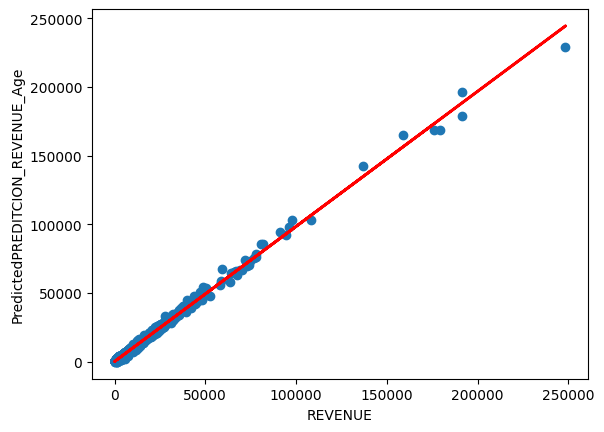

In [141]:
plt.scatter(y_test_prediction_merge['ACTUAL_REVENUE'], y_test_prediction_merge['PREDITCION_REVENUE'])

z = np.polyfit(y_test_prediction_merge['ACTUAL_REVENUE'], y_test_prediction_merge['PREDITCION_REVENUE'], 1)
p = np.poly1d(z)
plt.plot(y_test_prediction_merge['ACTUAL_REVENUE'], p(y_test_prediction_merge['ACTUAL_REVENUE']), color='red', linewidth=2, label='Trendlijn')

plt.xlabel('REVENUE')
plt.ylabel('PredictedPREDITCION_REVENUE_Age')
plt.show()

In [139]:
mean_squared_error(y_test_prediction_merge['actual_revenue'], y_test_prediction_merge['prediction_revenue'])

KeyError: 'actual_revenue'

In [ ]:
mean_absolute_error(y_test_prediction_merge['actual_revenue'], y_test_prediction_merge['prediction_revenue'])

9.909290632568906